In [143]:
import pandas as pd
import numpy as np
import os
import pyvis
import networkx as nx
from matplotlib import pyplot as plt
from itertools import product
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
# pip install --upgrade nbformat
# pip install -U kaleido

In [144]:
pd.set_option('display.max_columns', None)

In [145]:
CURRENT_DIRECTORY = os.getcwd()

In [146]:
def import_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Return the SKUs and Transactions datasets.  
    """
    skus_data = pd.read_csv(f"{CURRENT_DIRECTORY}/data/skus.csv", delimiter = ",")
    transactions_data = pd.read_csv(f"{CURRENT_DIRECTORY}/data/transactions.csv", delimiter = ",")
    return skus_data, transactions_data

skus_data, transactions_data = import_data()

In [ ]:
def merge_skus_transactions(df_skus : pd.DataFrame, df_transactions : pd.DataFrame) -> pd.DataFrame:
    """
    Merge SKUs and Transactions datasets.  
    """
    return df_transactions.merge(df_skus, on = "SKU", how = "left")
transactions_data = merge_skus_transactions(skus_data, transactions_data)

- **REVENUE = SALE_PRICE_EX_VAT * QTY**
- **SALE_PRICE_EX_VAT = NORMAL PRICE - DISCOUNT**

In [109]:
skus_data.columns

Index(['SKU', 'ITEM_DESCRIPTION', 'DEPARTMENT', 'CATEGORY', 'SUBCATEGORY1',
       'SUBCATEGORY2', 'BRAND', 'ITEM_WEIGHT', 'ITEM_UNIT_OF_MEASURE'],
      dtype='object')

### Departments and categories analysis

In [ ]:
def plot_hierarchical_categories(df : pd.DataFrame) -> None:
    """
    Save plot of the hierarchy within the SKUs data. Departments -> Categories -> etc.
    """
    hierarchical_categories = df[["DEPARTMENT", "CATEGORY"]].drop_duplicates()
    fig = px.treemap(hierarchical_categories, path=["DEPARTMENT", "CATEGORY"])
    fig.write_image(f"{CURRENT_DIRECTORY}/data/department_category_tree.png")
plot_hierarchical_categories(skus_data)

### Other SKUs in transactions that are not part of the list of 500 best-selling items

In [113]:
result = {x for x in transactions_data["SKU"].unique() if x not in skus_data["SKU"].unique()}
result

set()

# Missing data

In [114]:
transactions_data.isna().any()

TRANSACTION_ID          False
TRANSACTION_LINE_ID     False
STORE_ID                False
SKU                     False
SALE_PRICE_EX_VAT       False
REVENUE                 False
QTY                     False
DISCOUNT                False
ITEM_DESCRIPTION        False
DEPARTMENT              False
CATEGORY                False
SUBCATEGORY1            False
SUBCATEGORY2            False
BRAND                   False
ITEM_WEIGHT              True
ITEM_UNIT_OF_MEASURE     True
dtype: bool

### Missing SKUs in transactions

In [ ]:
def find_missing_SKU_transactions(df_skus : pd.DataFrame, df_transactions : pd.DataFrame) -> pd.DataFrame:
    """
    Return missing SKUs in the transactions dataset. 
    """
    list_skus = {x for x in df_skus["SKU"].unique() if x not in df_transactions["SKU"].unique()}
    return df_skus[df_skus["SKU"].isin(list_skus)]

find_missing_SKU_transactions(skus_data, transactions_data)

,SKU,ITEM_DESCRIPTION,DEPARTMENT,CATEGORY,SUBCATEGORY1,SUBCATEGORY2,BRAND,ITEM_WEIGHT,ITEM_UNIT_OF_MEASURE
46,65813,Sizzlers Bacon Treat Maxi,Dog,Treat,Other,Other,Bakers,0.001,KG
47,65815,Bacon/Cheese Whirlers Maxi,Dog,Treat,Other,Other,Bakers,0.001,KG
123,51849,Miss Purfect Strip Teasers,Cat,Treat,Other,Na,Miss Purfect,0.050,KG
134,54646,Beef Meat Only Dinner,Dog,Food,Frozen,Adult,Durham Animal Feeds,0.500,KG
189,30365,Delivery,Misc.,Na,Na,Na,NaN,NaN,NaN
367,50806,Naturals Gig Mv Chkn,Cat,Food,S.S.Wet,Adult,Gourmet,0.810,KG
498,65495,Chicken Mince,Dog,Food,Frozen,Adult,Raw And Simple,1.500,KG


### Count number of unique items sold together per transaction
A purchase will be a unique transaction with possibly multiple items sold at the same time (i.e.: same unique transacation ID).
We want to know the distribution of number of items sold per purchase.

In [156]:
def count_items_sold_transaction(df : pd.DataFrame) -> pd.DataFrame:
    """
    Count the number of items sold per basket for each transaction. 
    """
    return df.groupby(["TRANSACTION_ID"]).agg({
        "SKU" : lambda x : x.nunique()
    }).reset_index().value_counts("SKU")

sku_transactions_data = count_items_sold_transaction(transactions_data)

def nbre_transactions_mutliple_items(df : pd.DataFrame) -> float:
    """
    Return the ...
    """
    return round(1-df.loc[1]/df.sum(), 2)*100

print(nbre_transactions_mutliple_items(sku_transactions_data))

def plot_distribution_items_transaction(df : pd.DataFrame) -> None:
    """
    Save the distribution of numbe of items in a basket. 
    """
    plt.figure(figsize = (8,6))
    plt.bar(df.index, df.values,color='skyblue', edgecolor='black', alpha=0.8)
    plt.title("Distribution of the number of items in a basket", fontsize=12, fontweight='bold')
    plt.xlabel("Number of items per basket", fontsize=12)
    plt.ylabel("Number of basket with X items", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(f"{CURRENT_DIRECTORY}/data/nbre_items_per_transaction.png")
    plt.close()

plot_distribution_items_transaction(sku_transactions_data)

54.0


### Number of times an item has been bought

In [172]:
def calculate_items_bought(df : pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the number of times an item appears in a basket and sum the total revenue generated. 
    """
    return df.groupby(["SKU"]).agg(
        SKU_TOTAL_TRANSACTION = ("TRANSACTION_ID", "count"),
        SKU_TOTAL_REVENUE = ("REVENUE", "sum")
).reset_index()

df_item_purchases = calculate_items_bought(transactions_data)

df_item_purchases["SKU_TOTAL_TRANSACTION"].mean()

np.float64(9.91683569979716)

In [ ]:
def add_transaction_details_skus(df_skus : pd.DataFrame, df_baskets : pd.DataFrame) -> pd.DataFrame:
    """
    Add the Total Revenue and Total Number of transactions for every item.
    """
    return df_skus.merge(df_baskets, on = "SKU", how = "left")

skus_data = add_transaction_details_skus(skus_data, df_item_purchases)

# Low-frequence items analysis
What percentage of revenue do we lose by dropping low-frequency items?

**REVENUE = SALE_PRICE_EX_VAT * QTY**


In [178]:
def share_revenue_items_sold(df : pd.DataFrame, threshold_transactions : int) -> float:
    """
    Return percentage of revenue one keeps after dropping low-frequency items. 
    """
    return df[df["SKU_TOTAL_TRANSACTION"] >= threshold_transactions]["SKU_TOTAL_REVENUE"].sum()/df["SKU_TOTAL_REVENUE"].sum()
share_revenue_items_sold(skus_data, 6)

np.float64(0.7951121178296452)

### Check if a transaction ID is unique or unique per store

In [180]:
transactions_data.groupby("TRANSACTION_ID").agg({
    "STORE_ID" : lambda x : x.nunique()
    }
)["STORE_ID"].nunique()

1

Transaction ID is indeed unique across all the stores. It is not a unique Transaction ID per store.

### There are negative quantities. Is that returned items? We can drop them as it is only a few transactions.


In [181]:
def remove_anomalies(df : pd.DataFrame) -> pd.DataFrame:
    """
    Remove negative Quantity and Revenue for data consistency.
    """
    df = df[df["QTY"]>0]
    df = df[df["REVENUE"]> 0]
    return df

transactions_data = remove_anomalies(transactions_data)

### Effect of promotion on data

Flag if there is a discount applied and calculate the value of the discount

In [279]:
transactions_data_discount = transactions_data.copy()

In [280]:
def discount_flag_and_calculation(df : pd.DataFrame) -> pd.DataFrame:
    """
    Flag if a discount is applied on the item purchased for a transaction.
    Calculate the percentage of discount applied. 
    """
    ## Flag if a discount is applied to the sale
    df["DISCOUNT_APPLIED"] = df["DISCOUNT"].map(lambda x : 0 if x==0 else 1)

    ## Calculate the percentage of the discount applied
    df["DISCOUNT_VALUE"] = 1-df["SALE_PRICE_EX_VAT"]/(df["SALE_PRICE_EX_VAT"] + transactions_data_discount["DISCOUNT"])
    return df
transactions_data_discount = discount_flag_and_calculation(transactions_data_discount)

transactions_data_discount["DISCOUNT_APPLIED"].value_counts()

DISCOUNT_APPLIED
1    2299
0    2008
Name: count, dtype: int64

Flag SKUs with transactions with and without discount for further comparison

In [281]:
def flag_discounted_SKU(df : pd.DataFrame) -> pd.DataFrame:
        """
        Return SKUs which got sold discounted and not discounted over the past 3 months.
        """
        discount_df = df.groupby(["SKU"]).agg(
                DISCOUNT_NO_DISCOUNT = ("DISCOUNT_APPLIED", lambda x : x.nunique())
        ).reset_index()

        return df.merge(discount_df, on = "SKU", how = "left")

transactions_data_discount = flag_discounted_SKU(transactions_data_discount)
transactions_data_discount["DISCOUNT_NO_DISCOUNT"].value_counts()

DISCOUNT_NO_DISCOUNT
2    3163
1    1144
Name: count, dtype: int64

Measure impact of discount on sales volume

In [327]:
def filter_skus_per_discount_value(df : pd.DataFrame, threshold_discount_min : int) -> pd.DataFrame:
    """
    Keep transactions with a threshold_discount_min discount < threshold_discount_max and transactions with no discount.
    It will be used for further analysis to compare the effect of the discount percentage.
    """

    threshold_discount_max = threshold_discount_min+0.05
    ## Find SKUs that have been sold with at normal price and discounted price lower than the threshold
    sku_discount = df[df["DISCOUNT_VALUE"]>threshold_discount_min]["SKU"]

    ## Only keep the transaction for those SKUs
    df = df[(df["SKU"].isin(sku_discount))]

    ## Return only the transactions with a discount < threshold or no discount
    return df[(df["DISCOUNT_VALUE"].between(threshold_discount_min, threshold_discount_max)) | (df["DISCOUNT_APPLIED"]==0)]

In [328]:
def measure_sales_volume_per_transaction(df : pd.DataFrame) -> pd.DataFrame:
        """
        1. Find the volume of quantity sold with and without discount.
        2. Calculate the ratio of quantity sold per transaction.
        3. Return the average of the calculated ratio for transaction with and without discount for comparison.
        """
        ## Find the volume of quantity sold with and without discount
        qty_df = df.groupby(["SKU", "DISCOUNT_APPLIED"]).agg(
                QTY_SOLD = ("QTY", "sum"),
                NBRE_TRANSACTIONS = ("QTY", "count")
        )

        ## Calculate the ratio of quantity sold per transaction
        qty_df["RATIO_QTY_SOLD"] = qty_df["QTY_SOLD"]/qty_df["NBRE_TRANSACTIONS"]
        qty_df = qty_df.reset_index()

        ## Return the average of the calculated ratio for transaction with and without discount
        return qty_df[qty_df["DISCOUNT_APPLIED"]==0]["RATIO_QTY_SOLD"].mean(), qty_df[qty_df["DISCOUNT_APPLIED"]==1]["RATIO_QTY_SOLD"].mean()

In [329]:
def measure_impact_discount(df : pd.DataFrame, threshold_discount_max : float) -> list[list, list, list]:
    """
    Return the average ratio quantity/transactions for items sold without discount
    and items sold after applying a promotion lower than a threshold. 
    """
    all_threshold_discount = []
    all_ratio_no_discount = []
    all_ratio_discount = []
    
    ## Measure impact of discount for a range of thresholds
    for threshold_discount in np.arange(0, threshold_discount_max, 0.05):
        df1 = df.copy()
        df1 = df1[df1["DISCOUNT_NO_DISCOUNT"]==2]
        transactions_data_discount_filtered = filter_skus_per_discount_value(df1, threshold_discount)
        ratio_without_discount, ratio_with_discount = measure_sales_volume_per_transaction(transactions_data_discount_filtered)

        all_threshold_discount.append(threshold_discount)
        all_ratio_no_discount.append(ratio_without_discount)
        all_ratio_discount.append(ratio_with_discount)
    return all_threshold_discount, all_ratio_no_discount, all_ratio_discount

all_threshold_discount, all_ratio_no_discount, all_ratio_discount = measure_impact_discount(transactions_data_discount, 0.60)

In [330]:
df_impact_discount = pd.DataFrame({"DISCOUNT_VALUE" : all_threshold_discount, "SALES_RATIO_NO_DISCOUNT" : all_ratio_no_discount, "SALES_RATIO_WITH_DISCOUNT" : all_ratio_discount})
df_impact_discount["RELATIVE_DIFFERENCE"] = abs(df_impact_discount["SALES_RATIO_WITH_DISCOUNT"] - df_impact_discount["SALES_RATIO_NO_DISCOUNT"])/df_impact_discount["SALES_RATIO_WITH_DISCOUNT"]

In [334]:
# plt.figure(figsize = (8,6))
# plt.plot(df_impact_discount["DISCOUNT_VALUE"], df_impact_discount["RELATIVE_DIFFERENCE"], label = "SALES RATIO NO DISCOUNT")
# plt.xticks(df_impact_discount["DISCOUNT_VALUE"])
# plt.yticks()
# plt.legend()
# plt.grid()
# plt.show()

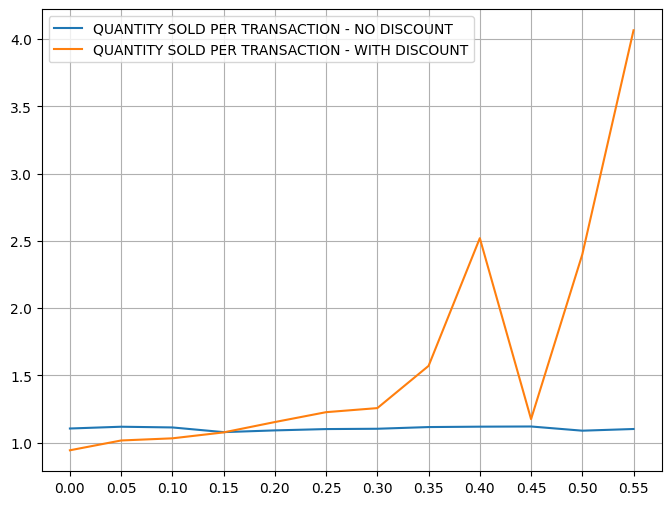

In [335]:
plt.figure(figsize = (8,6))
plt.plot(df_impact_discount["DISCOUNT_VALUE"], df_impact_discount["SALES_RATIO_NO_DISCOUNT"], label = "QUANTITY SOLD PER TRANSACTION - NO DISCOUNT")
plt.plot(df_impact_discount["DISCOUNT_VALUE"], df_impact_discount["SALES_RATIO_WITH_DISCOUNT"], label = "QUANTITY SOLD PER TRANSACTION - WITH DISCOUNT")
plt.xticks(df_impact_discount["DISCOUNT_VALUE"])
plt.yticks()
plt.legend()
plt.grid()
plt.show()